In [1]:
import pandas as pd
import seaborn as sns
import sklearn as sk

In [2]:
data = pd.read_csv("Train_data.csv")

# 1. 데이터 전처리

## 1.1. protocol_type 을 numerical data로

 protocol_type은 각 icmp, tcp, udp의 세 가지로 구분되어 있다. 하지만 training을 시킬 때 이러한 categorical data들은 사용하지 못하기 때문에, 이를 numerical data로 변환시킬 필요가 있다. scikit에서는 label encoder와 one hot encoder를 제공하는데, label encoder는 각각의 category를 숫자로 변환 (ex. icmp = 1, tcp = 2, udp =3)으로 해준다. 하지만 label encoding을 할 경우 knn과 같은 몇 가지 알고리즘에서 이를 수치값으로 인식하여 문제가 생길 수 있기 때문에, one hot encoder로 한 번 더 encoding 한다. 

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [4]:
le = LabelEncoder()
ohe = OneHotEncoder()

In [5]:
data.protocol_type = le.fit_transform(data.protocol_type)

In [6]:
data.protocol_type = ohe.fit_transform(data.protocol_type.values.reshape(-1, 1)).toarray()

## 1.2. x와 y로 나누기

 scikit에서 training을 위해서 class부분과 attribute 부분을 나눠야 한다. x는 모든 instance의 attribute항목에 따른 값들이고 y는 모든 instance들의 class이다.

In [7]:
x = data.iloc[:,:-1]
y = data.loc[:,'xAttack']

## 1.3. 데이터 분석 및 feature drop

주어진 데이터는 KDD Cup 1999 Dataset을 가공한 네트워크 침입 감시 시스템용 데이터이다. Class는 침입을 당했는지, 당했다면 어떤 침입을 당했는지에 대한 내용이며, normal, dos, u2r, r2l, probe의 5개의 class가 존재한다.

Train_data.csv파일에 있는 인스턴스 중 각 클래스의 갯수는 다음과 같다:

    normal : 67343
    dos : 45927
    probe : 11656
    u2r : 52
    r2l : 995

In [8]:
data.describe()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,125973.000000,125973.000000,125973.000000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,0.815167,32.086288,2.575179,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,...,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,0.388164,16.462574,1.141552,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,...,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,1.000000,20.000000,2.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,1.000000,25.000000,2.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,1.000000,50.000000,4.000000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.000000,70.000000,11.000000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


데이터를 보면, 75%이하가 0인 atrribute들이 더 많다. 더 자세하게 이를 살펴보기 위해서 excel을 이용해 csv파일을 열어서 각 항목 중 대부분이 0인 데이터들을 찾은 후, 이들이 class에 따라 특정한 값을 가지고 있는지, 즉 classify에 도움이 되는 attribute일지 판단해보았다.


      land / wrong_fragment /	urgent	/ hot /	num_failed_logins	/ num_compromised / root_shell	/ su_attempted	/ num_root	/ num_file_creations	/ num_shells	/ num_access_files	/ num_outbound_cmds	/ is_host_login	/ is_guest_login
  
위의 항목들은 대부분이 0을 차지하고 있는 atrribute들이다. 
우선적으로 모든 instance의 값이 0인 num_outbout_cmds와 1개 빼고 다 0인 is_host 두 개의 attribute은 삭제해주었다. 

In [9]:
x = x.drop('num_outbound_cmds', axis=1)
x = x.drop('is_host_login', axis=1)

    그리고 attribute중 많은 수가 0인데, 값이 있는 instance들도 class의 변화가 없는 attribute들도 삭제해준다.
    
    1) root_shell은 1이 170만개정도, 나머지는 0이었는데, 170만개의 1인 instance들의 class가 크게 다르지 않았다.
    2)su_attempt는 1이 80개인데, 대부분 normal이다. 
    3) num_root는 1이상인 값이 288개정도 인데, class차이가 크지 않다.
    4) num_shell도 1이상이 50개정도밖에 되지 않았다. 
    5) num_access_files도 1이상이 400만개정도 밖에 없었는데 대부분 normal이었다. 
    6) urgent는 값이 있는 instance가 9개인데, normal, dos, r2l이 다 섞여있어서 의미 없다고 판단햇다.
    7) land는 25개만이 1이고 나머지는 모두 0이다.
    8) wrong_fragment 1090개가 1~3사이의 정수값이다. 이들 대부분이 dos이다. 하지만 dos의 갯수가 45927개 이기 때문에 큰 의미가 없다고 판단했다.
    9) num_failed_logins : 122개가 1~5 사이의 정수값이다. r2l과 normal이 많았다. 하지만 역시 r2l이 995개인점을 고려하면 큰 의미가 없다고 판단했다.
    10) num_compromised 1286개의 데이터가 정수값을 가지고 있다. 편차가 꽤 큰 편인데, normal과 dos가 섞여있지만, normal와 dos를 합치면 약 십만개라는 점에서 무시 가능하다고 판단했다
    11) num_shells 47개만이값을 가진다.

In [10]:
x = x.drop('root_shell', axis=1)
x = x.drop('su_attempted', axis=1)
x = x.drop('num_root', axis=1)
x = x.drop('num_file_creations', axis=1)
x = x.drop('num_access_files', axis=1)
x = x.drop('is_guest_login', axis=1)
x = x.drop('urgent', axis=1)
x = x.drop('land', axis=1)
x = x.drop('wrong_fragment', axis = 1)
x = x.drop('num_failed_logins', axis=1)
x = x.drop('num_compromised', axis=1)
x = x.drop('num_shells', axis=1)

drop을 여기까지 했을 때 adaBoost가 성능이 제일 좋았고, 80%가까이 나왔지만, probe, r2l, u2r에 대한 판단이 없었다. 나머지는 다 40%정도로 성능이 낮았다. 이후에 dest_host_srv_count와 dest_host_count도 drop해 보았는데, 더 성능이 떨어졌다.

hot의 경우 2500개가량만 값을 가져서 처음에 제거했으나, 큰 값의 표현가 없어서 포함했다.

## 1.4. standardization

In [11]:
from sklearn import preprocessing

In [12]:
scaler = preprocessing.StandardScaler().fit(x)

In [13]:
x = scaler.transform(x)

## 1.5. x와 y를 training, test set으로 나누기

model을 만들때는 모든 dataset으로 트레이닝 하면 되지만, test set이 없다면 x와 y를 training set와 test set으로 나누어, training set으로 model을 만든 후에 test set으로 이를 검증해야 한다. 이를 위해서 나누어보았다. 여기에서는 40%를 test dataset로, 60%를 training set으로 만들었다

In [14]:
from sklearn.model_selection import train_test_split as tts

In [15]:
x_train, x_test, y_train, y_test = tts(x, y, test_size=0.4, random_state=0)

# 2. 기본적인 Algorithm 시도

## 2.1. Decision tree, MLP, adaBoost 해보기

Decision tree, MLP, adaBoost 등을 간단하게 위에서 나눈 training set으로 모델링 해보았다. 그리고 test set으로 accuracy를 확인해보았다.

### 2.1.1. import classifier package

In [16]:
from sklearn import tree

In [17]:
from sklearn.neural_network import MLPClassifier

In [18]:
from sklearn.ensemble import AdaBoostClassifier

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
from sklearn.neighbors import KNeighborsClassifier

In [21]:
from sklearn.naive_bayes import GaussianNB

### 2.1.2. get classifier

In [22]:
clf_tree = tree.DecisionTreeClassifier()

In [23]:
clf_mlp = MLPClassifier()

In [24]:
clf_ada = AdaBoostClassifier()

In [25]:
clf_rfc = RandomForestClassifier()

In [26]:
clf_knn = KNeighborsClassifier()

In [27]:
clf_gnb = GaussianNB()

### 2.1.3. training & build model

In [28]:
model_dt = clf_tree.fit(x_train, y_train)

In [29]:
model_mlp = clf_mlp.fit(x_train, y_train)

In [30]:
model_ada = clf_ada.fit(x_train, y_train)

In [31]:
model_rfc = clf_rfc.fit(x_train, y_train)

In [32]:
model_knn = clf_knn.fit(x_train, y_train)

In [33]:
model_gnb = clf_gnb.fit(x_train, y_train)

### 2.1.4. predict, accuracy 측정

In [34]:
from sklearn.metrics import accuracy_score

(1) Tree

In [35]:
x_test_pred = clf_tree.predict(x_test)

In [36]:
accuracy_score(y_test, x_test_pred)

0.9973804326255209

(2) MLP

In [37]:
x_test_pred = clf_mlp.predict(x_test)
accuracy_score(y_test, x_test_pred)

0.99464179400674735

(3) adaBoost

In [38]:
x_test_pred = clf_ada.predict(x_test)
accuracy_score(y_test, x_test_pred)

0.82768406429847197

(4) Random Forest

In [39]:
x_test_pred = clf_rfc.predict(x_test)
accuracy_score(y_test, x_test_pred)

0.99845207382417145

(5) Gaussian Naive Bayes

In [40]:
x_test_pred = clf_gnb.predict(x_test)
accuracy_score(y_test, x_test_pred)

0.80619170470331414

(6) KNN

In [41]:
x_test_pred = clf_knn.predict(x_test)
accuracy_score(y_test, x_test_pred)

0.99487993649533635

## 2.2. cross validation 해보기

In [42]:
from sklearn.model_selection import cross_val_score as cvs

In [43]:
scores_dt = cvs(clf_tree, x, y, cv = 10)
print("Tree Accuracy : %0.4f(+/- %0.2f)" %(scores_dt.mean(), scores_dt.std() * 2))

Tree Accuracy : 0.9977(+/- 0.00)


In [44]:
scores_mlp = cvs(clf_mlp, x, y, cv = 10)
print("MLP Accuracy : %0.4f(+/- %0.2f)" %(scores_mlp.mean(), scores_mlp.std() * 2))

MLP Accuracy : 0.9946(+/- 0.00)


In [45]:
scores_ada = cvs(clf_ada, x, y, cv = 10)
print("AdaBoost Accuracy : %0.4f(+/- %0.2f)" %(scores_ada.mean(), scores_ada.std() * 2))

AdaBoost Accuracy : 0.8454(+/- 0.08)


In [46]:
scores_rfc = cvs(clf_rfc, x, y, cv = 10)
print("Random Forest Accuracy : %0.4f(+/- %0.2f)" %(scores_rfc.mean(), scores_rfc.std() * 2))

Random Forest Accuracy : 0.9986(+/- 0.00)


In [47]:
scores_knn = cvs(clf_knn, x, y, cv = 10)
print("KNeighbors Accuracy : %0.4f(+/- %0.2f)" %(scores_knn.mean(), scores_knn.std() * 2))

KNeighbors Accuracy : 0.9954(+/- 0.00)


In [48]:
scores_gnb = cvs(clf_gnb, x, y, cv = 10)
print("Gaussian Naive Bayes Accuracy : %0.4f(+/- %0.2f)" %(scores_gnb.mean(), scores_gnb.std() * 2))

Gaussian Naive Bayes Accuracy : 0.7975(+/- 0.01)


## 2.3. graph 확인

In [49]:
from sklearn_evaluation import plot
from sklearn.model_selection import learning_curve, validation_curve

In [50]:
%matplotlib inline

(1) Tree

In [51]:
train_sizes, train_scores, test_scores = learning_curve(clf_tree, x, y)

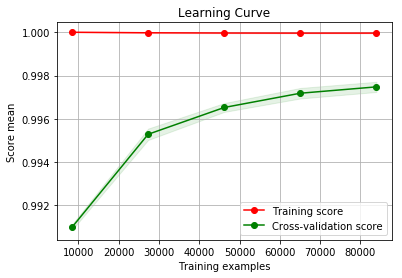

In [52]:
plot.learning_curve(train_scores, test_scores, train_sizes)

(2) MLP

In [53]:
train_sizes, train_scores, test_scores = learning_curve(clf_mlp, x, y)

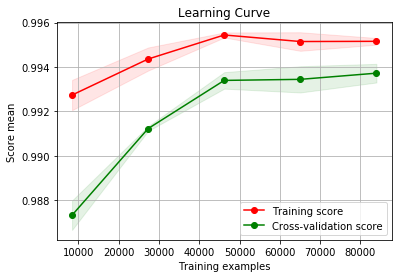

In [54]:
plot.learning_curve(train_scores, test_scores, train_sizes)

(3) adaBoost

In [55]:
train_sizes, train_scores, test_scores = learning_curve(clf_ada, x, y)

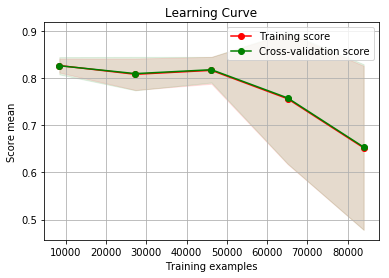

In [56]:
plot.learning_curve(train_scores, test_scores, train_sizes)

(4) Random Forest

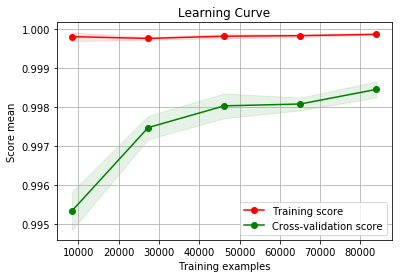

In [57]:
train_sizes, train_scores, test_scores = learning_curve(clf_rfc, x, y)
plot.learning_curve(train_scores, test_scores, train_sizes)

(5) Gaussian Naive Bayes

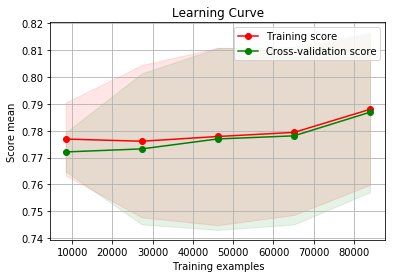

In [58]:
train_sizes, train_scores, test_scores = learning_curve(clf_gnb, x, y)
plot.learning_curve(train_scores, test_scores, train_sizes)

(6) KNN

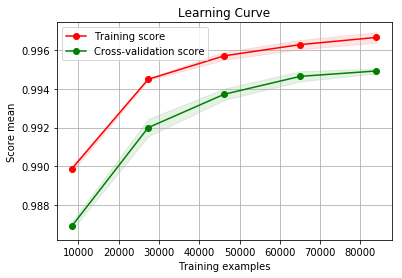

In [59]:
train_sizes, train_scores, test_scores = learning_curve(clf_knn, x, y)
plot.learning_curve(train_scores, test_scores, train_sizes)

## 2.4. 소결론

adaBoost와 Naive Bayes를 제외한 classifier들이 다 95% 이상의 성능을 냈다. Overfit의 가능성이 있기 때문에, 또 distribution이 다른 dataset에서는 다른 성능을 낼 수도 있으므로, testset을 불러와서 이를 가지고 다시 성능 테스트를 해보기로 한다.

# 3. test data로 test해보기

final model 제출 후 test할 data set과 같은 distribution을 가진 test_data.csv 데이터로 각 모델에 대한 accuracy를 측정해 보았다. 모두 두 번의 encoding을 거쳤으며, drop과 standardization을 모두 한 모델이다.

## 3.1. test data 불러오기

In [60]:
testdata = pd.read_csv('test_data.csv')

In [61]:
testdata

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,xAttack
0,0,icmp,25,4,0,0,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.65,0.65,0.32,0.32,dos
1,0,icmp,25,2,312,1856,0,0,0,0,...,254,1.00,0.00,1.00,0.06,0.00,0.00,0.00,0.00,normal
2,0,icmp,25,2,245,2058,0,0,0,0,...,255,1.00,0.00,0.01,0.05,0.01,0.00,0.00,0.00,normal
3,0,icmp,25,2,298,1267,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
4,0,icmp,20,2,740,0,0,0,0,0,...,19,0.18,0.03,0.18,0.00,0.00,0.00,0.00,0.00,normal
5,0,icmp,25,2,304,16414,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
6,0,icmp,29,3,0,44,0,0,0,0,...,54,0.21,0.02,0.00,0.00,0.00,0.00,0.78,0.98,probe
7,0,icmp,25,5,42340,7300,0,0,0,1,...,255,1.00,0.00,0.00,0.00,0.01,0.01,0.07,0.07,dos
8,4,icmp,48,2,32,93,0,0,0,0,...,124,0.87,0.02,0.01,0.02,0.00,0.00,0.07,0.00,r2l
9,0,icmp,25,2,249,5656,0,0,0,0,...,242,1.00,0.00,0.01,0.04,0.00,0.00,0.00,0.00,normal


## 3.2. test data encoding, divide into x&y, feature selection

In [62]:
testdata.protocol_type = le.fit_transform(testdata.protocol_type)

In [63]:
testdata.protocol_type = ohe.fit_transform(testdata.protocol_type.values.reshape(-1, 1)).toarray()

In [64]:
testdata_x = testdata.iloc[:,:-1]
testdata_y = testdata.loc[:,'xAttack']

In [65]:
testdata_x = testdata_x.drop('num_outbound_cmds', axis=1)
testdata_x = testdata_x.drop('is_host_login', axis=1)
testdata_x = testdata_x.drop('root_shell', axis=1)
testdata_x = testdata_x.drop('su_attempted', axis=1)
testdata_x = testdata_x.drop('num_root', axis=1)
testdata_x = testdata_x.drop('num_file_creations', axis=1)
testdata_x = testdata_x.drop('num_access_files', axis=1)
testdata_x = testdata_x.drop('is_guest_login', axis=1)
testdata_x = testdata_x.drop('urgent',axis=1)
testdata_x = testdata_x.drop('land', axis=1)
testdata_x = testdata_x.drop('wrong_fragment', axis = 1)
testdata_x = testdata_x.drop('num_failed_logins', axis=1)
testdata_x = testdata_x.drop('num_compromised', axis=1)
testdata_x = testdata_x.drop('num_shells', axis=1)

In [66]:
scaler.transform(testdata_x)

array([[ -1.10249223e-01,   4.76175266e-01,  -4.30450094e-01, ...,
          8.33616103e-01,   6.56219511e-01,   6.25309214e-01],
       [ -1.10249223e-01,   4.76175266e-01,  -4.30450094e-01, ...,
         -6.24870800e-01,  -3.87634624e-01,  -3.76387026e-01],
       [ -1.10249223e-01,   4.76175266e-01,  -4.30450094e-01, ...,
         -6.24870800e-01,  -3.87634624e-01,  -3.76387026e-01],
       ..., 
       [ -1.10249223e-01,  -2.10006708e+00,   1.08815201e+00, ...,
         -6.24870800e-01,  -3.87634624e-01,  -3.76387026e-01],
       [ -1.10249223e-01,   4.76175266e-01,  -4.30450094e-01, ...,
         -6.24870800e-01,  -3.87634624e-01,  -3.76387026e-01],
       [ -1.97528901e-03,   4.76175266e-01,  -7.34170514e-01, ...,
         -6.24870800e-01,   2.28724160e+00,  -3.76387026e-01]])

## 3.3. 각종 algorithm으로 test해보기

training은 training dataset의 x와 y 즉 전체 training dataset을 가지고 했으며, evaluation은 위에서 말한대로, test_data.csv로 했다. Accuracy측정 후에는 confusion_matrix를 그려본다

In [226]:
!pip install sklearn_evaluation

In [67]:
from sklearn.metrics import confusion_matrix

In [68]:
import matplotlib.pyplot as plt

(1) tree

In [69]:
model_dt = clf_tree.fit(x,y)

In [70]:
dt_pred = model_dt.predict(testdata_x)

In [71]:
accuracy_score(testdata_y, dt_pred)

0.38290000000000002

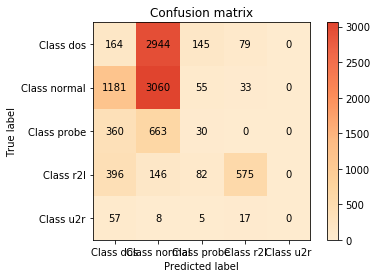

In [72]:
plot.confusion_matrix(testdata_y, dt_pred)
plt.show()

normal이나 r2l은 잘 맞추고 있지만 dos엔 취약한 모습을 보인다. 전체적인 성능이 낮다

(2) mlp 

In [73]:
model_mlp = clf_mlp.fit(x,y)

In [74]:
mlp_pred = model_mlp.predict(testdata_x)

In [75]:
accuracy_score(testdata_y, mlp_pred)

0.21160000000000001

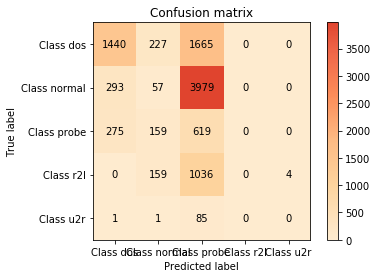

In [76]:
plot.confusion_matrix(testdata_y, mlp_pred)
plt.show()

mlp는 probe을 어느정도 맞춰내고 있지만 normal 과 dos에 대한 성능이 좋지 않다. 그리고 tree에 비해서 dos와 probe로 판단하는 양이 많고, 오히려 가장 데이터 수가 많은 normal로 판단하는 경우가 상대적으로 적다. 

(3) naive bayes

In [77]:
model_gnb = clf_gnb.fit(x, y)

In [78]:
gnb_pred = model_gnb.predict(testdata_x)

In [79]:
accuracy_score(testdata_y, gnb_pred)

0.089899999999999994

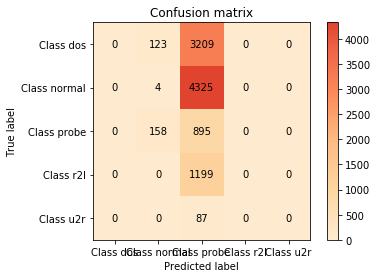

In [80]:
plot.confusion_matrix(testdata_y, gnb_pred)
plt.show()

(4) Random Forest

In [81]:
model_rf = clf_rfc.fit(x,y)

In [82]:
rfc_pred = model_rfc.predict(testdata_x)

In [83]:
accuracy_score(testdata_y, rfc_pred)

0.46589999999999998

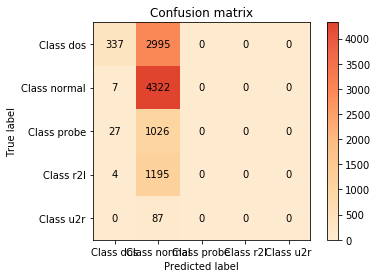

In [84]:
plot.confusion_matrix(testdata_y, rfc_pred)
plt.show()

random forest는 dos와 normal에만 치중하는 모습이 보인다. 하지만 전체적인 성능은 나쁘지 않다.

(5) adaBoost

In [85]:
model_ada = clf_ada.fit(x,y)

In [86]:
ada_pred = model_ada.predict(testdata_x)

In [87]:
accuracy_score(testdata_y, ada_pred)

0.49730000000000002

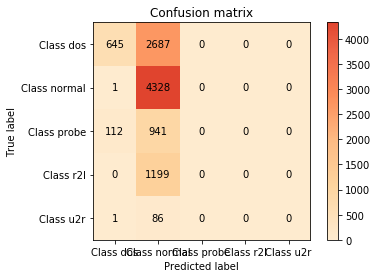

In [88]:
plot.confusion_matrix(testdata_y, ada_pred)
plt.show()

dos와 normal에 대해서 높은 성능을 내고 있지만, 모든 data를 dos와 normal로 판단하고 있어서 소수의 class에 대해서는 성능이 매우 안좋다.

(6) KNN

In [89]:
model_knn = clf_knn.fit(x,y)

In [90]:
knn_pred = model_knn.predict(testdata_x)

In [91]:
accuracy_score(testdata_y, knn_pred)

0.094600000000000004

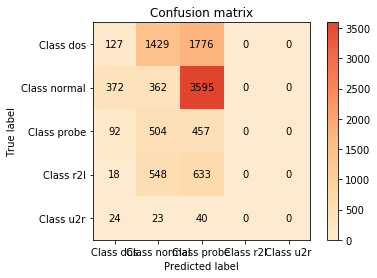

In [92]:
plot.confusion_matrix(testdata_y, knn_pred)
plt.show()

성능이 매우 나쁘다. KNN은 작은 데이터 값 하나에도 예민하게 반응하는 경향이 있어서 normal과 dos가 다수임에도 불구하고 probe에 치중해있다. 하지만 r2l과 u2r에 대해서도 성능이 매우 나쁘다.

## 3.4. 소결론

가장 좋은 성과를 낸 것은 AdaBoost이지만 probe, u2r, r2l등에 대한 판단을 전혀 내리고 있지 않은 것 같다. 따라서 이 외에도 Random Forest와 MLP를 더 살펴보기로 한다. 하지만 모든 classifier 들이 50%이하의 성능을 내고 있는것으로 보아 feature selection에 문제가 있을 수도 있다. 따라서 임의 drop이 아닌 PCA를 사용해보기로한다.

# 4. PCA

## 4.1. drop하지 않은 dataset을 pca로 가공하기

In [93]:
x_pca = data.iloc[:,:-1]
y_pca = data.loc[:,'xAttack']

In [94]:
scaler = preprocessing.StandardScaler().fit(x_pca)
x_pca = scaler.transform(x_pca)

In [95]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 5).fit(x_pca)
x_pca = pca.transform(x_pca)

## 4.2. testdata를 pca로 가공하기

In [96]:
testdata_pca = pd.read_csv('test_data.csv') # 다시 불러옴
testdata_pca.protocol_type = le.fit_transform(testdata_pca.protocol_type) # le encoding
testdata_pca.protocol_type = ohe.fit_transform(testdata_pca.protocol_type.values.reshape(-1, 1)).toarray()
# encoding 해서 protocol type을 다 바굼
x_testdata_pca = testdata_pca.iloc[:,:-1]
y_testdata_pca = testdata_pca.loc[:,'xAttack']
# 학습을 위해 x와 y로 나눔
x_testdata_pca = scaler.transform(x_testdata_pca)
# x를 standardize함
x_testdata_pca = pca.transform(x_testdata_pca)
#위에서 사용한 pca로 feature를 줄인다

## 4.3. Random Forest 

(1) pca한 data의 cross validation

In [97]:
scores_rf = cvs(clf_rfc, x_pca, y_pca, cv = 10)
print("Random Forest Accuracy : %0.4f(+/- %0.2f)" %(scores_rf.mean(), scores_rf.std() * 2))

Random Forest Accuracy : 0.9946(+/- 0.00)


(2) pca한 test dataset test

In [98]:
model_pca = clf_rfc.fit(x_pca, y_pca)

In [99]:
pred_pca = model_pca.predict(x_testdata_pca)

In [100]:
accuracy_score(y_testdata_pca, pred_pca)

0.73070000000000002

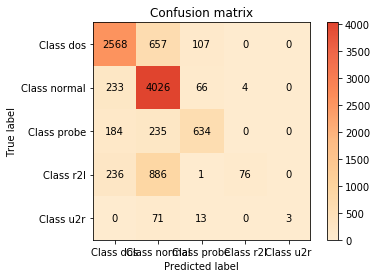

In [101]:
plot.confusion_matrix(y_testdata_pca, pred_pca)
plt.show()

PCA가 성능이 훨씬 좋다. 다수인 normal, dos뿐만아니라 probe와 r2l도 이전보다 잘 찾아내고 있다. 다른 clasifier algorithm도 pca한 데이터를 사용해본다. 

Random Forest의 성능이 좋으므로, 다른 것도 시도해본다.

(3) estimator 수 변경

In [102]:
clf_rf2 = RandomForestClassifier(n_estimators = 10)
model_pca2 = clf_rf2.fit(x_pca, y_pca)
pred_pca2 = model_pca2.predict(x_testdata_pca)
accuracy_score(y_testdata_pca, pred_pca2)

0.73619999999999997

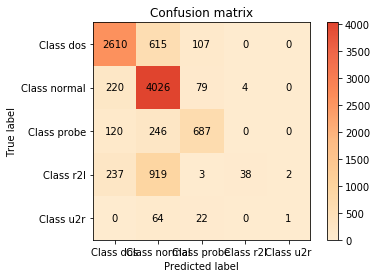

In [103]:
plot.confusion_matrix(y_testdata_pca, pred_pca2)
plt.show()

(4) criterion 변경

In [104]:
clf_rf3 = RandomForestClassifier(criterion = 'entropy')
model_pca3 = clf_rf3.fit(x_pca, y_pca)
pred_pca3 = model_pca3.predict(x_testdata_pca)
accuracy_score(y_testdata_pca, pred_pca3)

0.73599999999999999

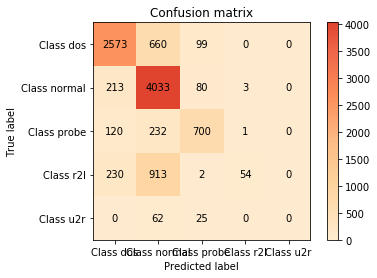

In [105]:
plot.confusion_matrix(y_testdata_pca, pred_pca3)
plt.show()

## 4.4. MLP

(1) pca한 data의 cross validation

In [106]:
scores_mlp = cvs(clf_mlp, x_pca, y_pca, cv = 10)
print("MLP Accuracy : %0.4f(+/- %0.2f)" %(scores_mlp.mean(), scores_mlp.std() * 2))

MLP Accuracy : 0.9842(+/- 0.00)


(2) pca한 test dataset test

In [107]:
model_pca = clf_mlp.fit(x_pca, y_pca)
pred_pca = model_pca.predict(x_testdata_pca)
accuracy_score(y_testdata_pca, pred_pca)

0.72050000000000003

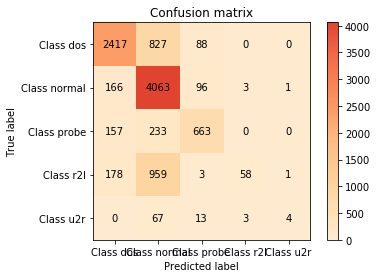

In [108]:
plot.confusion_matrix(y_testdata_pca, pred_pca)
plt.show()

(3) hidden layer 바꿔보기

In [109]:
clf_mlp2 = MLPClassifier(hidden_layer_sizes = 5)
model_pca2 = clf_mlp2.fit(x_pca, y_pca)
pred_pca2 = model_pca2.predict(x_testdata_pca)
accuracy_score(y_testdata_pca, pred_pca2)

0.72570000000000001

(4) activation function 바꿔보기

In [110]:
clf_mlp3 = MLPClassifier(activation = 'logistic')
model_pca3 = clf_mlp3.fit(x_pca, y_pca)
pred_pca3 = model_pca3.predict(x_testdata_pca)
accuracy_score(y_testdata_pca, pred_pca3)

0.72860000000000003

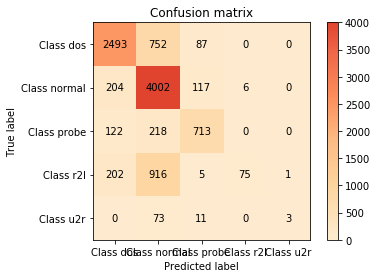

In [111]:
plot.confusion_matrix(y_testdata_pca, pred_pca3)
plt.show()

## 4.5. AdaBoost 

(1) pca한 data의 cross validation

In [114]:
scores_ada= cvs(clf_ada, x_pca, y_pca, cv = 10)
print("AdaBoost Accuracy : %0.4f(+/- %0.2f)" %(scores_ada.mean(), scores_ada.std() * 2))

AdaBoost Accuracy : 0.5194(+/- 0.23)


(2) pca한 test dataset test

In [113]:
model_pca = clf_ada.fit(x_pca, y_pca)
pred_pca = model_pca.predict(x_testdata_pca)
accuracy_score(y_testdata_pca, pred_pca)

0.4723

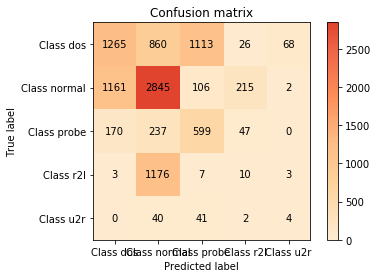

In [115]:
plot.confusion_matrix(y_testdata_pca, pred_pca)
plt.show()

## 4.6. SVM

feature drop 이후에도 time complexity 가 너무 높아 해보지 못했던 SVM을 해본다. PCA를 통해 dimension을 줄였으니 충분히 가능할 것으로 보인다.

In [116]:
from sklearn.svm import SVC
clf_svc = SVC()

(1) pca한 data의 cross validation

In [117]:
scores_svm = cvs(clf_svc, x_pca, y_pca, cv = 10)
print("SVM Accuracy : %0.4f(+/- %0.2f)" %(scores_svm.mean(), scores_svm.std() * 2))

SVM Accuracy : 0.9761(+/- 0.00)


(2) pca한 test dataset test

In [118]:
model_pca = clf_svc.fit(x_pca, y_pca)
pred_pca = model_pca.predict(x_testdata_pca)
accuracy_score(y_testdata_pca, pred_pca)

0.73060000000000003

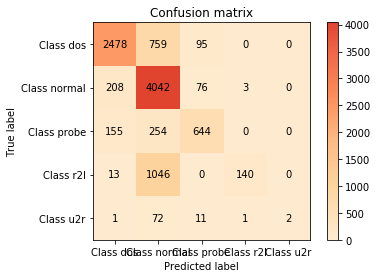

In [119]:
plot.confusion_matrix(y_testdata_pca, pred_pca)
plt.show()

(3) 다른 svm classifier

svm이 성능이 좋으므로, parameter를 조정해서 시도해본다.

In [120]:
clf_svc2 = SVC(kernel = 'poly')
model_pca2 = clf_svc2.fit(x_pca, y_pca)
pred_pca2 = model_pca2.predict(x_testdata_pca)
accuracy_score(y_testdata_pca, pred_pca2)

0.7218

In [121]:
clf_svc3 = SVC(kernel = 'sigmoid')
model_pca3 = clf_svc3.fit(x_pca, y_pca)
pred_pca3 = model_pca3.predict(x_testdata_pca)
accuracy_score(y_testdata_pca, pred_pca3)

0.5544

## 4.7. 소결론

PCA는 dimension reduction 방법으로, feature 관게를 통해 새로운 feature를 만들어낼 수 있다는 특성을 가지고 있다. 아마 PCA가 높은 성능은 낸 것은, network intrusion을 파악하는 방법 때문인 것 같다. 에를 들어서 dos 공격 같은 경우, icmp protocol에서 패킷들이 너무 많이 들어온다던지, 혹시 tcp protocol에서 SYN이 지나치게 많이 들어온다던지 하는 상황은 모두 dos로 의심해볼 수 있듯이, protocol_type과 패킷 rate을 합치면 더 좋은 classify를 위한 기준이 될 수 있을 것으로 보인다. 

# 5. 최종 모델

사실 Random Forest의 모든 model들이 좋은 성능을 냈고, MLP의 model들도 좋았고, SVM도 좋아서 큰 차이는 없었지만, 상대적으로 Random Forest의 model building 속도가 빨랐다는 점, parameter를 변경해도 일정하게 성능이 좋았다는 점 때문에 Random Forest를 최종 선정하였다.

아래는 데이터를 새로 load해서 처음부터 모든 데이터 전처리를 고치고, model을 만든 후,10-fold cross validation과 test_data,csv를 통해 성능을 측정하고, metrics까지 그린 결과이다.

In [122]:
data_final = pd.read_csv('Train_data.csv')
data_final.protocol_type = le.fit_transform(data_final.protocol_type)
data_final.protocol_type = ohe.fit_transform(data_final.protocol_type.values.reshape(-1, 1)).toarray()
x_final = data_final.iloc[:,:-1]
y_final = data_final.loc[:,'xAttack']
scaler_final = preprocessing.StandardScaler().fit(x_final)
x_final = scaler_final.transform(x_final)
from sklearn.decomposition import PCA
pca = PCA(n_components = 5).fit(x_final)
x_final = pca.transform(x_final)

In [123]:
clf_final = RandomForestClassifier()
model_final = clf_final.fit(x_final, y_final)

In [124]:
scores = cvs(clf_final, x_final, y_final, cv = 10)
print("Accuracy : %0.4f(+/- %0.2f)" %(scores.mean(), scores.std() * 2))

Accuracy : 0.9946(+/- 0.00)


In [125]:
pred = model_final.predict(x_testdata_pca)
accuracy_score(y_testdata_pca, pred)

0.73160000000000003

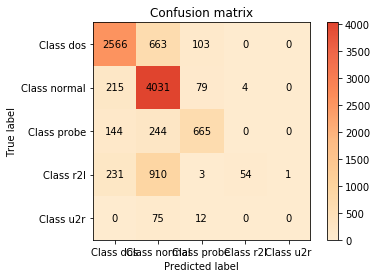

In [126]:
plot.confusion_matrix(y_testdata_pca, pred)
plt.show()